# Word2Vec then RNN

## Imports and setting up TensorBoard

In [8]:
from data_preparation import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, Dropout, Embedding
from keras.optimizers import Adam
from keras_train_helper import tfauc, rotateTensorboardLogs, PrintAucCallback, plotLearningCurve
from keras.regularizers import L1L2
from tensorflow.python.client import device_lib
from keras.callbacks import TensorBoard

tensorBoardCallback = TensorBoard(log_dir="../tb-logs")
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3012059913321078016
]


## Loading data and setting up preprocessing tools

In [2]:
train, test, allData, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


### Split sentences and apply word correction & splitting

In [3]:
%%time
from sklearn.pipeline import Pipeline

maxSeqLength = 250

splitter = SentenceSplitter("comment_text")
wordEmbedding = loadWordEmbedding("../../state/external-models/glove.6B/saved-2300.bin")

allWords = splitter.transform(pd.concat([allData, contestTest]))
textWords = set([word for sentence in allWords for word in sentence])
missingWords = textWords - set(list(wordEmbedding.vocab.keys()))

missingWordsResolutionDict = loadObject("./missingWordsResolution.plk")
missingWordsResolver = MissingWordsResolver(missingWordsResolutionDict, missingWords)

splittingPipeline = Pipeline(steps=[
    ("split", splitter),
    ("resolveMissingWords", missingWordsResolver) ])

Splitting sentences...
CPU times: user 14.9 s, sys: 584 ms, total: 15.5 s
Wall time: 15.5 s


### W2I and zero padding

In [4]:
%%time
resolvedWords = missingWordsResolver.transform(allWords)

w2i = Word2Int(resolvedWords)
zeroPadder = ZeroPadder(maxSeqLength)

indexingPipeline = Pipeline(steps=[
    ("w2i", w2i),
    ("zeroPadding", zeroPadder)
])

Resolving missing words...
Loading w2i and i2w dictionaries...
CPU times: user 8.27 s, sys: 88 ms, total: 8.36 s
Wall time: 8.36 s


In [5]:
preparationPipeline = Pipeline(steps=[
    ("splittingPipeline", splittingPipeline),
    ("indexingPipeline", indexingPipeline)
])

### W2V

In [6]:
%%time
w2v = Word2Vec(wordEmbedding, 300, w2i.i2w, seed=4324)

Loading word2vec dictionary...
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 79.4 ms


In [7]:
embeddingMatrix, i2v = w2v.embeddingMatrix()

## Define the model

### Define the model

In [10]:
lstmUnits = 100
numClasses = 2
batchSize = 1024

def defineModel(dropout, recurrent_dropout):
    model = Sequential()

    model.add(Embedding(
        embeddingMatrix.shape[0],
        embeddingMatrix.shape[1],
        weights=[embeddingMatrix],
        input_length=maxSeqLength,
        trainable=False))

    model.add(Bidirectional(LSTM(
        lstmUnits, 
        dropout=dropout, 
        recurrent_dropout=recurrent_dropout, 
        bias_regularizer=L1L2(l1=0.01, l2=0.01),
        name="LSTM")))

    model.add(Dense(
        2, 
        activation="softmax", 
        name="softmax_output"))
    
    model.compile(
        loss="categorical_crossentropy", 
        optimizer="nadam", 
        metrics=[tfauc])

    print(model.summary())
    return model

## Prepare data and train the model

In [11]:
def fitModel(model, trainDataset, testDataset, printAucCallback, label, epochs, fast=False):
    print("Training model for target variable: {}".format(label))
    
    tf.set_random_seed(43245)
    np.random.seed(453252)
    
    labelizer = Labelizer(label)
    oversampler = Oversampler(label)
    
    trainOversampled = oversampler.transform(trainDataset)

    trainSentences = preparationPipeline.transform(trainOversampled)
    trainLabels = labelizer.transform(trainOversampled)
    testSentences = preparationPipeline.transform(testDataset)
    testLabels = labelizer.transform(testDataset)

    printAucCallback.setDatasets([trainSentences, trainLabels], [testSentences, testLabels])

    model.fit(
        trainSentences, 
        trainLabels, 
        nb_epoch=epochs, 
        batch_size=batchSize,
        callbacks=[] if fast else [tensorBoardCallback, printAucCallback])
    
    return model, testSentences, testLabels

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          59772900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               320800    
_________________________________________________________________
softmax_output (Dense)       (None, 2)                 402       
Total params: 60,094,102
Trainable params: 321,202
Non-trainable params: 59,772,900
_________________________________________________________________
None
Training model for target variable: toxic
Oversampling...
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...


/home/mariosk/anaconda2/envs/ipykernel_py3/lib/python3.6/site-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/2
1024/1890 [===============>..............] - ETA: 12s - loss: 2.7405 - tfauc: 0.5171 - train auc: 0.7925
 - test auc: 0.7598


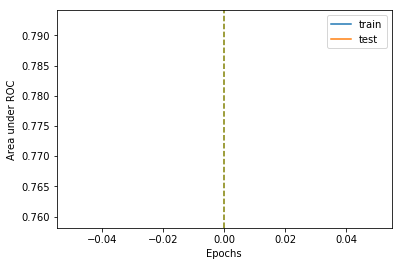

1890/1890 [==============================] - 36s 19ms/step - loss: 2.7964 - tfauc: 0.5176
Epoch 2/2
1024/1890 [===============>..............] - ETA: 12s - loss: 2.6980 - tfauc: 0.5440 - train auc: 0.8267
 - test auc: 0.7810


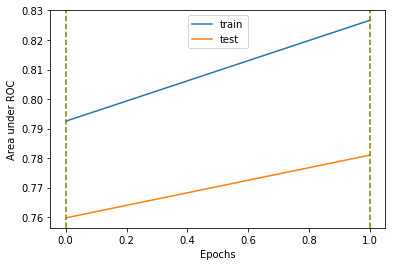

1890/1890 [==============================] - 37s 19ms/step - loss: 2.6604 - tfauc: 0.5557
CPU times: user 4min 24s, sys: 15.4 s, total: 4min 39s
Wall time: 1min 17s


In [12]:
%%time
model = defineModel(0.6, 0.2)
printAucCallback = PrintAucCallback(8192, printFrequency=0.02)

model, testSentences, testLabels = fitModel(model, train, test, printAucCallback, "toxic", 20)

## Compare train and test data

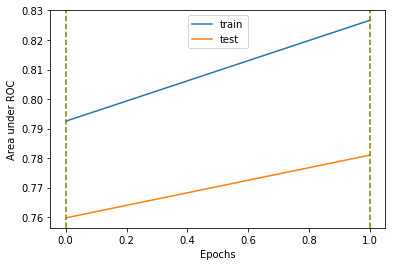

In [13]:
plotLearningCurve(printAucCallback.listOfAucsTrain, printAucCallback.listOfAucsTest)

           P Neutral  P Toxic
T Neutral        556      341
T Toxic           21       82


           P Neutral  P Toxic
T Neutral      0.556    0.341
T Toxic        0.021    0.082


0.312


0.7126


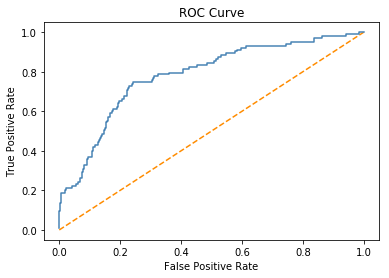

In [14]:
from evaluate_predictions import evaluatePredictions

predictions = model.predict(testSentences, batch_size=4*batchSize)
binaryPredictions = np.where(predictions[:, 1] > 0.5, 1, 0)
labels = testLabels[:, 1]

evaluatePredictions(pd.Series(labels), binaryPredictions, predictions)

## Run on all data and export submission

In [ ]:
%%time
contestModels = [
    fitModel(defineModel(dropout, recurrent_dropout), allData, test, PrintAucCallback(8192, printFrequency=0.02), label, epochs, fast=True)
    for (label, epochs)
    in [("toxic", 6, 0.6, 0.2), 
        ("severe_toxic", 1, 0.6, 0.2), 
        ("obscene", 3, 0.6, 0.2), 
        ("threat", 2, 0.8, 0.3), 
        ("insult", 2, 0.6, 0.2), 
        ("identity_hate", 1, 0.6, 0.2)]]

In [ ]:
%%time
categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
contestPredictionProbabilities = {
    category: model[0].predict(preparationPipeline.transform(contestTest), batch_size=8192) 
    for (category, model) in zip(categories, contestModels)}

In [33]:
suffledResult = pd.DataFrame(dict(
    [("id", contestTest.id)] 
    + [(name, preds[:, 1]) for (name, preds) in contestPredictionProbabilities.items()]))

result = suffledResult[["id"] + categories]

In [34]:
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.107428,0.086610,0.179781,0.043975,0.104099,0.086608
1,0000247867823ef7,0.147077,0.124943,0.256728,0.045869,0.097912,0.125053
2,00013b17ad220c46,0.144134,0.122432,0.231361,0.073960,0.156137,0.122611
3,00017563c3f7919a,0.094946,0.076373,0.186833,0.022637,0.050725,0.076566
4,00017695ad8997eb,0.105768,0.083794,0.182512,0.037039,0.066183,0.083650


In [ ]:
result.shape

In [45]:
result.to_csv("./submissions/w2v-then-rnn-increased-dropout.csv", index=False)